<a href="https://colab.research.google.com/github/suuungwoo/TensorFlow-Core/blob/master/eager_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Eager Execution の基本](https://www.tensorflow.org/guide/eager?hl=ja)

In [0]:
import tensorflow as tf

In [0]:
tf.executing_eagerly()

True

In [0]:
x = [[2.]]
m = tf.matmul(x,x)
print("hello, {}".format(m))

hello, [[4.]]


In [0]:
a = tf.constant([[1,2],[3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


# 動的な制御フロー

In [0]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buz')
        else:
            print(num.numpy())
        counter += 1

In [0]:
fizzbuzz(15)

1
2
Fizz
4
Buz
Fizz
7
8
Fizz
Buz
11
Fizz
13
14
FizzBuzz


# Eager Executionによる学習

In [0]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w
    
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [0]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
    tf.cast(mnist_labels, tf.int64)))

In [0]:
dataset = dataset.shuffle(1000).batch(32)

In [0]:
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu', input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [0]:
for images, labels in dataset.take(1):
    print("Logits:", mnist_model(images[0:1]).numpy())

Logits: [[ 0.0083715   0.00628064 -0.02502911 -0.01615733 -0.00340629  0.00803594
   0.01283177  0.01418977  0.00503082  0.00062695]]


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [0]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        loss_value = loss_object(labels, logits)
        
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [0]:
def train():
    for epoch in range(3):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print("Epoch {} finished".format(epoch))
            
train()

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


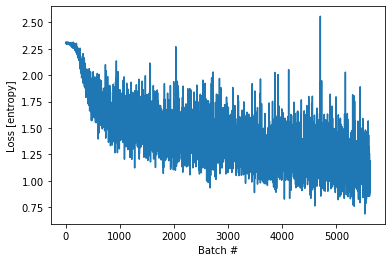

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

In [0]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
        
    def call(self, inputs):
        return inputs * self.W + self.B
    
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))
        
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.617
Loss at step 000: 65.946
Loss at step 020: 29.990
Loss at step 040: 13.917
Loss at step 060: 6.733
Loss at step 080: 3.521
Loss at step 100: 2.085
Loss at step 120: 1.443
Loss at step 140: 1.156
Loss at step 160: 1.028
Loss at step 180: 0.971
Loss at step 200: 0.945
Loss at step 220: 0.934
Loss at step 240: 0.929
Loss at step 260: 0.926
Loss at step 280: 0.925
Final loss: 0.925
W = 3.0281543731689453, B = 2.0171244144439697
